# IMPORTANT PIPELINE DEVELOPMENT USING SCIKIT LEARN 

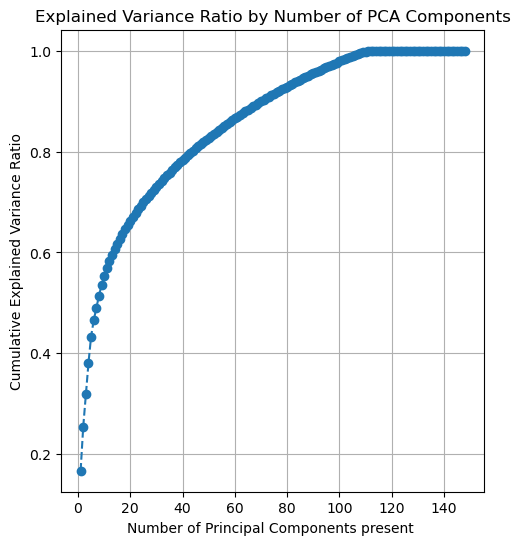

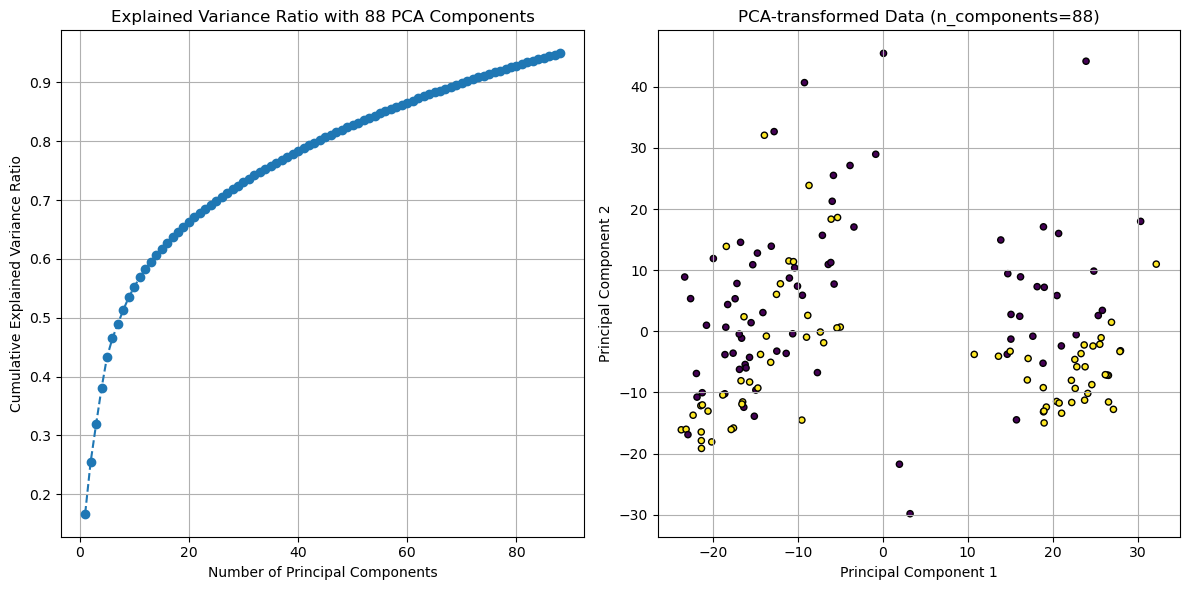

Components: 70, Train Accuracy: 1.0000, Test Accuracy: 0.8125
Components: 71, Train Accuracy: 1.0000, Test Accuracy: 0.7500
Components: 72, Train Accuracy: 0.9932, Test Accuracy: 0.7917
Components: 73, Train Accuracy: 1.0000, Test Accuracy: 0.6667
Components: 74, Train Accuracy: 1.0000, Test Accuracy: 0.7917
Components: 75, Train Accuracy: 0.9932, Test Accuracy: 0.8333
Components: 76, Train Accuracy: 0.9865, Test Accuracy: 0.8542
Components: 77, Train Accuracy: 1.0000, Test Accuracy: 0.7917
Components: 78, Train Accuracy: 1.0000, Test Accuracy: 0.8542
Components: 79, Train Accuracy: 0.9865, Test Accuracy: 0.7083
Components: 80, Train Accuracy: 1.0000, Test Accuracy: 0.7708
Components: 81, Train Accuracy: 0.9932, Test Accuracy: 0.7500
Components: 82, Train Accuracy: 1.0000, Test Accuracy: 0.8750
Components: 83, Train Accuracy: 1.0000, Test Accuracy: 0.7708
Components: 84, Train Accuracy: 1.0000, Test Accuracy: 0.7708
Components: 85, Train Accuracy: 0.9932, Test Accuracy: 0.8750
Componen

/var/folders/v_/dyrfqm3s1xv4w6jlpr0vgc280000gn/T/ipykernel_31986/2525245973.py:411: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  modified_annotation_df = pd.read_csv(annotation_file_path)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
random_seed = 100
# To rename Race column 
class RaceReplace(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Race'] = X['Race'].replace({'race: Caucasian/White': 'White', 'race: White': 'White'})
        return X

# log transformation 
class LogTran(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        numerical_columns = X.select_dtypes(include=[np.number]).columns
        X[numerical_columns] = X[numerical_columns].apply(lambda x: np.log1p(x))
        return X

# Removing outliers
class OutlierRemoverByIQR_method(BaseEstimator, TransformerMixin):
    def __init__(self, pattern='at'):
        self.pattern = pattern
        self.probe_ID = []
        self.outliers_per = {}
        self.outliers_above_thres = {}
        self.initial_max = {}
        self.initial_min = {}
        self.new_max = {}
        self.new_min = {}

    def fit(self, X, y=None):
        self.probe_ID = [col for col in X.columns if self.pattern in col]
        numeric_columns = X.select_dtypes(include=['number']).columns
        
        for probe_ID in numeric_columns:
            if probe_ID in X.columns:
                self.initial_max[probe_ID] = X[probe_ID].max()
                self.initial_min[probe_ID] = X[probe_ID].min()
                
                Q1 = X[probe_ID].quantile(0.25)
                Q3 = X[probe_ID].quantile(0.75)
                IQR = Q3 - Q1
                outliers = (X[probe_ID] < (Q1 - 1.5 * IQR)) | (X[probe_ID] > (Q3 + 1.5 * IQR))
                outlier_per = (outliers.sum() / len(X)) * 100
                self.outliers_per[probe_ID] = outlier_per

                if outlier_per > 10:
                    self.outliers_above_thres[probe_id] = outlier_per
        
        return self

    def transform(self, X):
        df_filtered = X.copy()
        self.plot_boxplots(X, title='Before Removing outlier by IQR method', columns=self.outliers_above_thres.keys())

        for probe_ID in self.outliers_above_thres.keys():
            if probe_ID in df_filtered.columns:
                max_value = self.initial_max[probe_id]
                df_filtered = df_filtered[df_filtered[probe_ID] != max_value]
        
        for probe_ID in self.outliers_above_thres.keys():
            if probe_ID in df_filtered.columns:
                self.new_max_values[probe_ID] = df_filtered[probe_ID].max()
                self.new_min_values[probe_ID] = df_filtered[probe_ID].min()
        
        self.plot_boxplots(df_filtered, title='After Outlier Removal', columns=self.outliers_above_thres.keys())
        
        #print("Initial Maximum values:", self.initial_max_values)
        #print("Initial Minimum values:", self.initial_min_values)
        #print("New Maximum values (after removing outliers):", self.new_max_values)
        #print("New Minimum values (after removing outliers):", self.new_min_values)
        
        return df_filtered

    def plot_boxplots(self, df, title='Boxplot', columns=None):
        if columns is None:
            columns = df.columns
        
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=df[columns])
        plt.xticks(rotation=90)
        plt.title(title)
        plt.xlabel('Columns')
        plt.ylabel('Values')
        plt.show()

# Load Data
df = pd.read_csv('/Users/swetarai/Desktop/machine_learning_2/merged_data.csv')

# Apply custom transformers
pipeline = Pipeline([
    ('outlier_remover', OutlierRemoverByMax(pattern='at'))  # Remove rows with max values and plot
])
df_transformed = pipeline.fit_transform(df)

# Apply label encoding to categorical columns
label_encoders = {}
categorical_columns = df_transformed.select_dtypes(include=[object]).columns
for column in categorical_columns:
    le = LabelEncoder()
    df_transformed[column] = le.fit_transform(df_transformed[column].astype(str))
    label_encoders[column] = le

# Extract features and target variable
X = df_transformed.drop(columns=['Disease_state'])
y = df_transformed['Disease_state']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('race', ReplaceRaceValues(), ['Race']),
        ('log', LogTransformer(), X.select_dtypes(include=[np.number]).columns)
    ],
    remainder='passthrough'
)

# Define and apply preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])
X_processed = pipeline.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Function to determine optimal PCA components and plot results
def determine_optimal_pca_components(X, y, variance_threshold=0.95):
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.title('Explained Variance Ratio by Number of PCA Components')
    plt.xlabel('Number of Principal Components present ')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    
    optimal_components = next(i for i, var in enumerate(cumulative_explained_variance) if var >= variance_threshold) + 1
    
    return optimal_components, pca

# Determine the optimal number of PCA components
optimal_components, pca = determine_optimal_pca_components(X_train_resampled, y_train_resampled)

# Apply PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
X_train_resampled_pca_optimal = pca_optimal.fit_transform(X_train_resampled)

# Plot PCA results
plt.figure(figsize=(12, 6))

# Plot the explained variance ratio after selecting optimal components
explained_variance_ratio_optimal = pca_optimal.explained_variance_ratio_
cumulative_explained_variance_optimal = explained_variance_ratio_optimal.cumsum()

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio_optimal) + 1), cumulative_explained_variance_optimal, marker='o', linestyle='--')
plt.title(f'Explained Variance Ratio with {optimal_components} PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)

# Plot PCA-transformed data
plt.subplot(1, 2, 2)
plt.scatter(X_train_resampled_pca_optimal[:, 0], X_train_resampled_pca_optimal[:, 1], c=y_train_resampled, cmap='viridis', edgecolor='k', s=20)
plt.title(f'PCA-transformed Data (n_components={optimal_components})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.tight_layout()
plt.show()




def evaluate_pca_components_range(X_train, y_train, X_test, y_test, min_components=70, max_components=120):
    results = {}
    specific_component = 85
    
    # Define the RandomForestClassifier with the given parameters
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=10,
        criterion='gini',
        max_depth=None,
        min_samples_split=3,
        min_samples_leaf=1
    )
    
    for n_components in range(min_components, max_components + 1):
        # Apply PCA with current number of components
        pca = PCA(n_components=n_components, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Train the model
        model.fit(X_train_pca, y_train)
        
        # Predict and calculate accuracies
        y_train_pred = model.predict(X_train_pca)
        y_test_pred = model.predict(X_test_pca)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        results[n_components] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
        print(f'Components: {n_components}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # Save the score for PCA components = 79
        if n_components == specific_component:
            with open('pca_component_79_scores.txt', 'w') as f:
                f.write(f'Components: {n_components}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return results

# Example usage
results = evaluate_pca_components_range(X_train_resampled, y_train_resampled, X_test, y_test)


def train_and_save_model_with_pca(X_train, y_train, X_test, y_test, n_components=85):
    # RandomForestClassifier with the given parameters
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=10,
        criterion='gini',
        max_depth=None,
        min_samples_split=3,
        min_samples_leaf=1
    )
    
    # pca with specified commponents
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train the model
    model.fit(X_train_pca, y_train)
    
    # Predict and calculate accuracies
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Print the accuracy scores
    print(f'PCA Components: {n_components}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Save the model to a file
    model_filename = 'random_forest_pca_84_model.pkl'
    joblib.dump(model, model_filename)
    print(f'Model saved as {model_filename}')
    
    return model

# Example usage
model = train_and_save_model_with_pca(X_train_resampled, y_train_resampled, X_test, y_test)


def train_and_predict_with_pca(X_train, y_train, X_test, y_test, n_components=85):
    # Define the RandomForestClassifier with the given parameters
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=10,
        criterion='gini',
        max_depth=None,
        min_samples_split=3,
        min_samples_leaf=1
    )
    
    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train the model
    model.fit(X_train_pca, y_train)
    
    # Predict on the test data
    y_test_pred = model.predict(X_test_pca)
    
    # Convert numeric labels to descriptive names
    label_mapping = {0: 'Control', 1: 'JIA'}  
    
    y_test_descriptive = [label_mapping[label] for label in y_test]
    y_test_pred_descriptive = [label_mapping[pred] for pred in y_test_pred]
    
    # Create a DataFrame for comparison with descriptive names
    comparison_df = pd.DataFrame({
        'Original Class': y_test_descriptive,
        'Predicted Class': y_test_pred_descriptive
    })
    
    # Print the first 20 rows of the comparison DataFrame
    print(comparison_df.head(20))
    
    # Calculate and print accuracies
    train_accuracy = accuracy_score(y_train, model.predict(X_train_pca))
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'PCA Components: {n_components}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Save the model to a file
    model_filename = '/Users/swetarai/Desktop/machine_learning_2/random_forest_pca_84_model.pkl'
    joblib.dump(model, model_filename)
    print(f'Model saved as {model_filename}')
    
    return model


model = train_and_predict_with_pca(X_train_resampled, y_train_resampled, X_test, y_test)

import pandas as pd
from sklearn.decomposition import PCA

def rank_genes_by_contribution(X_train, gene_names, n_components):
    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    
    # Get the contributions of each gene to the PCA components
    contributions = pd.DataFrame(pca.components_, columns=gene_names)
    
    # Sum contributions across all PCA components to get overall contribution of each gene
    gene_contributions = contributions.abs().sum(axis=0)
    
    # Create DataFrame for ranking
    top_genes_df = pd.DataFrame({
        'Gene': gene_contributions.index,
        'Contribution': gene_contributions.values
    })
    
    # Sort by contribution
    top_genes_df = top_genes_df.sort_values(by='Contribution', ascending=False)
    
    # Get the top 50 genes
    top_50_genes_df = top_genes_df.head(50)
    
    return top_50_genes_df

# Load your dataset
df_2 = pd.read_csv('/Users/swetarai/Desktop/machine_learning_2/merged_data.csv')

# Extract only numeric columns for features
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
X = df_2[numeric_columns]

# Ensure 'probe' and 'Disease_state' are not included in X
X = X.drop(columns=['Disease_state'], errors='ignore')

# Extract gene names from 'probe' column and ensure it's separate
gene_names = df['probe'].tolist()

# Extract target variable
y = df['Disease_state']

# Ensure gene_names matches the numeric columns in X
gene_names = numeric_columns

# Apply PCA with the number of components used in your model
n_components = 85
top_50_genes_df = rank_genes_by_contribution(X, gene_names, n_components)

# Save the top 50 genes DataFrame to a CSV file
top_50_genes_df.to_csv('/Users/swetarai/Desktop/machine_learning_2/top_50_genes_pca_84.csv', index=False)
print('Top 50 genes saved to top_50_genes_pca_84.csv')
top_50_genes_df


def annotate_top_genes(annotation_file_path, top_genes_file_path, output_file_path):
    # Read the CSV files into DataFrames
    modified_annotation_df = pd.read_csv(annotation_file_path)
    top_50_genes_df = pd.read_csv(top_genes_file_path)

    # Merge the two DataFrames based on the probe ID (Gene in top_50_genes_df and probe in modified_annotation_df)
    annotated_genes_df = pd.merge(top_50_genes_df, modified_annotation_df, left_on='Gene', right_on='probe', how='left')

    # Select relevant columns: Gene (probe), Contribution, Gene Title, Gene Symbol
    annotated_genes_selected = annotated_genes_df[['Gene', 'Contribution', 'Gene Title', 'Gene Symbol']]

    # Save the resulting DataFrame to a new CSV file
    annotated_genes_selected.to_csv(output_file_path, index=False)
    
    # Return the resulting DataFrame
    return annotated_genes_selected

# Example usage
annotation_file_path = '/Users/swetarai/Desktop/ML_data_source/annotation/modified_annotation.csv'
top_genes_file_path = '/Users/swetarai/Desktop/machine_learning_2/top_50_genes_pca_84.csv'
output_file_path = '/Users/swetarai/Desktop/machine_learning_2/top_50_genes_annotation_PCA_84.csv'

result_df = annotate_top_genes(annotation_file_path, top_genes_file_path, output_file_path)
print(result_df.head())

